In [31]:
from time import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from matplotlib.ticker import FuncFormatter
from xgboost import XGBRegressor  

In [32]:
df = pd.read_csv('data/stocks.csv')

In [33]:
df

,date,close,high,low,open,volume,ticker,dollar_vol,dollar_vol_1m,dollar_vol_rank,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015-07-06,38.426975,38.504885,38.046083,38.054738,23034000,MSFT,8.851269e+08,4.491610e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
1,2015-07-07,38.349068,38.513547,37.500714,38.383695,36435800,MSFT,1.397279e+09,4.547745e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
2,2015-07-08,38.297127,38.868467,38.115334,38.470258,39785900,MSFT,1.523686e+09,4.578243e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
3,2015-07-09,38.539524,39.145492,38.522210,38.738627,32424700,MSFT,1.249633e+09,4.675900e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
4,2015-07-10,38.617428,39.076231,38.582800,38.963693,25465800,MSFT,9.834237e+08,4.783547e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21316,2024-11-22,229.056870,229.903869,227.253275,227.253275,38168300,AAPL,8.742711e+09,3.370178e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21317,2024-11-25,232.046249,232.424910,228.927332,230.641249,90152800,AAPL,2.091962e+10,3.317622e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21318,2024-11-26,234.228500,234.736706,232.504624,232.504624,45986200,AAPL,1.077128e+10,3.283385e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21319,2024-11-27,234.098953,234.856275,232.982920,233.640589,33498400,AAPL,7.841940e+09,3.275652e+10,1.0,...,False,False,False,False,False,False,False,False,True,False


In [34]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'ticker',
       'dollar_vol', 'dollar_vol_1m', 'dollar_vol_rank', 'rsi', 'bb_high',
       'bb_low', 'atr', 'macd', 'return_1d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'lag_return_1d',
       'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'target_1d',
       'target_5d', 'target_10d', 'target_21d', 'year_2016', 'year_2017',
       'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022',
       'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [35]:
columns_to_drop = [c for c in df.columns if 'lag' in c] + ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume'] + [c for c in df.columns if 'year' in c] + [c for c in df.columns if 'month' in c]
print(f"Columns to drop: {columns_to_drop}")
print(f"Available columns: {list(df.columns)}")

# Only drop columns that actually exist
existing_lag_columns = [c for c in columns_to_drop if c in df.columns]
if existing_lag_columns:
    df = df.drop(existing_lag_columns, axis=1)
    print(f"Dropped {len(existing_lag_columns)} columns")
else:
    print("No lag columns found to drop")

Columns to drop: ['lag_return_1d', 'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
Available columns: ['date', 'close', 'high', 'low', 'open', 'volume', 'ticker', 'dollar_vol', 'dollar_vol_1m', 'dollar_vol_rank', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d', 'return_63d', 'lag_return_1d', 'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'target_1d', 'target_5d', 'target_10d', 'target_21d', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 

In [36]:
df.columns

Index(['date', 'ticker', 'dollar_vol_1m', 'rsi', 'bb_high', 'bb_low', 'atr',
       'macd', 'return_1d', 'return_5d', 'return_10d', 'return_21d',
       'return_42d', 'return_63d', 'target_1d', 'target_5d', 'target_10d',
       'target_21d'],
      dtype='object')

In [37]:
df.set_index(['ticker', 'date'], inplace=True)

### Split data

In [38]:
dates_available = df.index.get_level_values('date').unique()
dates_available

Index(['2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17',
       ...
       '2024-11-15', '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21',
       '2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29'],
      dtype='object', name='date', length=2369)

In [39]:
split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

1895

split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

In [40]:
split_date = dates_available[split_index_id]
split_date

'2023-01-12'

In [41]:
train_df = df[df.index.get_level_values('date') < split_date]
test_df = df[df.index.get_level_values('date') >= split_date]

In [42]:
print(train_df.shape)
print(test_df.shape)

(17055, 16)
(4266, 16)


In [43]:
y_train = train_df.filter(like='target')
y_test = test_df.filter(like='target')
X_train = train_df.drop(y_train.columns, axis=1)
X_test = test_df.drop(y_test.columns, axis=1)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17055, 12)
(4266, 12)
(17055, 4)
(4266, 4)


In [45]:
class CV:
    """Generate tuples of train-idx, test_idx pairs"""
    def __init__(self,
            n_splits=3,
            train_period_length=63,
            test_period_length=10,
            lookahead=None):
        self.n_splits = n_splits
        self.train_length = train_period_length
        self.test_length = test_period_length
        self.lookahead = lookahead

    def split(self, X, y=None, groups=None):   # <-- added groups
        unique_dates = X.index.get_level_values('date').unique()
        dates_df = X.reset_index()[['date']]
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        for train_start, train_end, test_start, test_end in split_idx:
            if train_start >= len(days) or test_end < 0:
                continue
            train_idx = dates_df[(dates_df.date > days[train_start])
                                 & (dates_df.date <= days[train_end])].index
            test_idx = dates_df[(dates_df.date > days[test_start])
                                & (dates_df.date <= days[test_end])].index
            if len(train_idx) > 0 and len(test_idx) > 0:
                yield train_idx, test_idx

In [46]:
train_period_length = 63
test_period_length = 10
n_splits = int(len(X_train.index.get_level_values('date').unique()) / test_period_length) 
lookahead = 1

cv = CV(n_splits=n_splits,
        train_period_length=train_period_length,  
        test_period_length=test_period_length,    
        lookahead=lookahead)

In [47]:
i = 0
for train_idx, test_idx in cv.split(X=X_train):
    train = X_train.iloc[train_idx]
    test = X_train.iloc[test_idx]
    
    # Get actual date values
    train_dates = train.reset_index()['date']
    test_dates = test.reset_index()['date']
    
    # Count stocks per period and show date ranges
    train_stock_count = len(train['ticker'].unique()) if 'ticker' in train.columns else len(train)
    test_stock_count = len(test['ticker'].unique()) if 'ticker' in test.columns else len(test)
    
    print(f"Split {i+1}: 63 {train_dates.min()} to {train_dates.max()}, "
          f"10 {test_dates.min()} to {test_dates.max()}")
    
    i += 1
    if i == 10:
        break

Split 1: 63 2022-09-28 to 2022-12-27, 10 2022-12-28 to 2023-01-11
Split 2: 63 2022-09-14 to 2022-12-12, 10 2022-12-13 to 2022-12-27
Split 3: 63 2022-08-30 to 2022-11-28, 10 2022-11-29 to 2022-12-12


Split 4: 63 2022-08-16 to 2022-11-11, 10 2022-11-14 to 2022-11-28
Split 5: 63 2022-08-02 to 2022-10-28, 10 2022-10-31 to 2022-11-11
Split 6: 63 2022-07-19 to 2022-10-14, 10 2022-10-17 to 2022-10-28
Split 7: 63 2022-07-05 to 2022-09-30, 10 2022-10-03 to 2022-10-14
Split 8: 63 2022-06-17 to 2022-09-16, 10 2022-09-19 to 2022-09-30
Split 9: 63 2022-06-03 to 2022-09-01, 10 2022-09-02 to 2022-09-16
Split 10: 63 2022-05-19 to 2022-08-18, 10 2022-08-19 to 2022-09-01


In [48]:
target = f'target_{lookahead}d'
target

'target_1d'

In [91]:
outcome_data = (X_train
                .join(y_train[[target]])
                .dropna())
print(f"Training rows (with target): {outcome_data.shape[0]} | Features: {X_train.shape[1]}")

def spearman_ic(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

spearman_scorer = make_scorer(spearman_ic, greater_is_better=True)

xgb_grid = {
    "learning_rate":     [0.03, 0.1],
    "max_depth":         [4, 6],
    "min_child_weight":  [3],
    "subsample":         [0.7],
    "colsample_bytree":  [0.7],
}

# 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'learning_rate': 0.1

X_for_cv = outcome_data.drop(columns=[target])
precomputed_splits = list(cv.split(X_for_cv))  # reuse existing custom CV indices

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='gpu_hist',      # change to 'gpu_hist' if GPU available
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

gcv = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_grid,
    scoring=spearman_scorer,
    cv=precomputed_splits,
    n_jobs=-1,
    refit=False,
    verbose=1
)
gcv.fit(X_for_cv, outcome_data[target])

cv_results_df = (pd.DataFrame(gcv.cv_results_)
                 .sort_values("rank_test_score")
                 .reset_index(drop=True))
display(cv_results_df.head(10))
print("Best (overall IC scorer) params:", cv_results_df.iloc[0].params)

Training rows (with target): 17055 | Features: 12
Fitting 183 folds for each of 4 candidates, totalling 732 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_subsample,params,...,split176_test_score,split177_test_score,split178_test_score,split179_test_score,split180_test_score,split181_test_score,split182_test_score,mean_test_score,std_test_score,rank_test_score
0,3.369855,0.047849,0.027390,0.004646,0.7,0.10,4,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",...,0.237486,0.051554,0.051340,0.140058,-0.033148,0.054978,0.079936,0.048139,0.125808,1
1,4.414004,0.049276,0.029583,0.004139,0.7,0.03,6,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,0.207902,-0.000305,0.044442,0.139219,0.016702,0.010396,-0.008289,0.038925,0.132714,2
2,4.342878,0.390629,0.029022,0.006101,0.7,0.10,6,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",...,0.173956,0.048640,-0.104449,0.161773,-0.025493,0.007729,-0.013179,0.037212,0.133683,3
3,3.562446,0.672217,0.027183,0.005267,0.7,0.03,4,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,0.277656,0.000469,0.130345,0.083912,-0.080331,-0.002642,-0.142496,0.036784,0.134582,4


Best (overall IC scorer) params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7}


In [92]:
best_params = cv_results_df.iloc[0].params
best_params_model = {
    k: best_params[k] for k in [
        "max_depth",
        "subsample",
        "colsample_bytree",
        "min_child_weight",
        "learning_rate",

    ]
}
print("Best Params:", best_params_model)

Best Params: {'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'learning_rate': 0.1}


In [93]:
val_days = int(len(dates_available) * 0.08)
all_dates = sorted(X_train.index.get_level_values('date').unique())
val_start = all_dates[-val_days]

X_tr_in = X_train[X_train.index.get_level_values('date') < val_start]
y_tr_in = y_train.loc[X_tr_in.index][target]
X_val = X_train[X_train.index.get_level_values('date') >= val_start]
y_val = y_train.loc[X_val.index][target]

best_params = cv_results_df.iloc[0].params
# Allow many trees; early stopping will cut
final_es = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    n_estimators=2000,
    eval_metric='rmse',
    early_stopping_rounds=100,
    **best_params
)
final_es.fit(
    X_tr_in, y_tr_in,
    eval_set=[(X_val, y_val)],
    verbose=False
)
print("Best iteration:", final_es.best_iteration, "Best score:", final_es.best_score)

# Refit on full training with optimal trees
best_n = final_es.best_iteration + 1
refit_model = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    n_estimators=best_n,
    **best_params
)
refit_model.fit(X_train, y_train[target])
y_test_pred = refit_model.predict(X_test)
y_test_pred = refit_model.predict(X_test)

Best iteration: 2 Best score: 0.03117931034057459


In [94]:
# Predict on test
y_test_pred = final_model.predict(X_test)

In [95]:
# Assemble test predictions
test_predictions = y_test[[target]].copy()
test_predictions['predicted'] = y_test_pred
test_predictions.columns = ['actuals', 'predicted']

In [96]:
# Compute per-day IC & RMSE on test
test_day_groups = test_predictions.groupby(level='date')
test_daily_ic = test_day_groups.apply(lambda df: spearmanr(df.actuals, df.predicted)[0]).to_frame('ic')
test_daily_rmse = test_day_groups.apply(lambda df: np.sqrt(mean_squared_error(df.actuals, df.predicted))).to_frame('rmse')
print("Test Mean Daily IC: {:.2%}".format(test_daily_ic.ic.mean()))
print("Test Overall IC: {:.2%}".format(spearmanr(test_predictions.actuals, test_predictions.predicted)[0]))
print("Test Mean Daily RMSE:", test_daily_rmse.rmse.mean())

Test Mean Daily IC: 2.48%
Test Overall IC: 2.61%
Test Mean Daily RMSE: 0.021224798061760367


In [97]:
# Portfolio construction (long/short)
predictions_unstacked = test_predictions['predicted'].unstack('ticker')
actuals_unstacked = test_predictions['actuals'].unstack('ticker')

In [98]:
N_LONG = 1
N_SHORT = 1

In [76]:
long_signals = ((predictions_unstacked
                 .where(predictions_unstacked > 0)
                 .rank(axis=1, ascending=False) <= N_LONG).astype(int))
short_signals = ((predictions_unstacked
                  .where(predictions_unstacked < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT).astype(int))

In [77]:
long_returns = (long_signals * actuals_unstacked).sum(axis=1) / long_signals.sum(axis=1)
short_returns = (short_signals * (-actuals_unstacked)).sum(axis=1) / short_signals.sum(axis=1)

In [78]:
strategy_returns = long_returns.fillna(0) + short_returns.fillna(0)
market_returns = actuals_unstacked.mean(axis=1)

In [79]:
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1
cumulative_market_returns = (1 + market_returns).cumprod() - 1

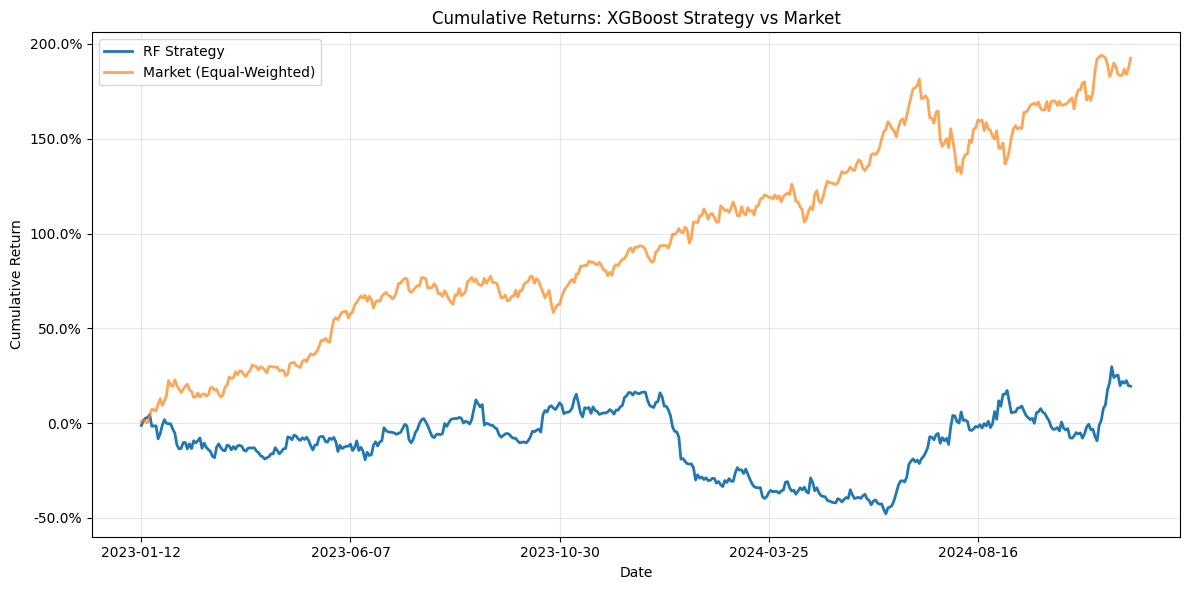

In [80]:
plt.figure(figsize=(12,6))
cumulative_strategy_returns.plot(label='RF Strategy', linewidth=2)
cumulative_market_returns.plot(label='Market (Equal-Weighted)', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns: XGBoost Strategy vs Market')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
sharpe_strategy = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std()!=0 else np.nan
sharpe_market = market_returns.mean() / market_returns.std() * np.sqrt(252) if market_returns.std()!=0 else np.nan

print(f"Strategy Total Return: {cumulative_strategy_returns.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns.iloc[-1]:.2%}")
print(f"Strategy Sharpe Ratio: {sharpe_strategy:.2f}")
print(f"Market Sharpe Ratio: {sharpe_market:.2f}")

Strategy Total Return: 19.48%
Market Total Return: 192.46%
Strategy Sharpe Ratio: 0.44
Market Sharpe Ratio: 2.43
